# Notes on Chapter 2 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

## Download the housing data

In [1]:
import tarfile
import urllib
from pathlib import Path
import shutil
from tempfile import TemporaryFile

housing_dataset_path = Path('datasets') / 'housing' / 'housing.csv'

def fetch_housing_data(
    source_url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz',
    dest_path = housing_dataset_path
    ):
    # create the destination directory, if needed
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    
    # download the compressed data into a temporary file
    with TemporaryFile() as tempfile:
        with urllib.request.urlopen(source_url) as download:
            shutil.copyfileobj(download, tempfile)

        # extract the compressed data
        tempfile.seek(0)
        with tarfile.open(fileobj=tempfile) as tarobj:
            tarobj.extract(dest_path.name, path=dest_path.parent)

In [2]:
if not housing_dataset_path.exists():
    fetch_housing_data()

## Exploratory data analysis

In [3]:
import pandas as pd

housing = pd.read_csv(housing_dataset_path)

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
from matplotlib import pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1dc672e748>,
      dtype=object)

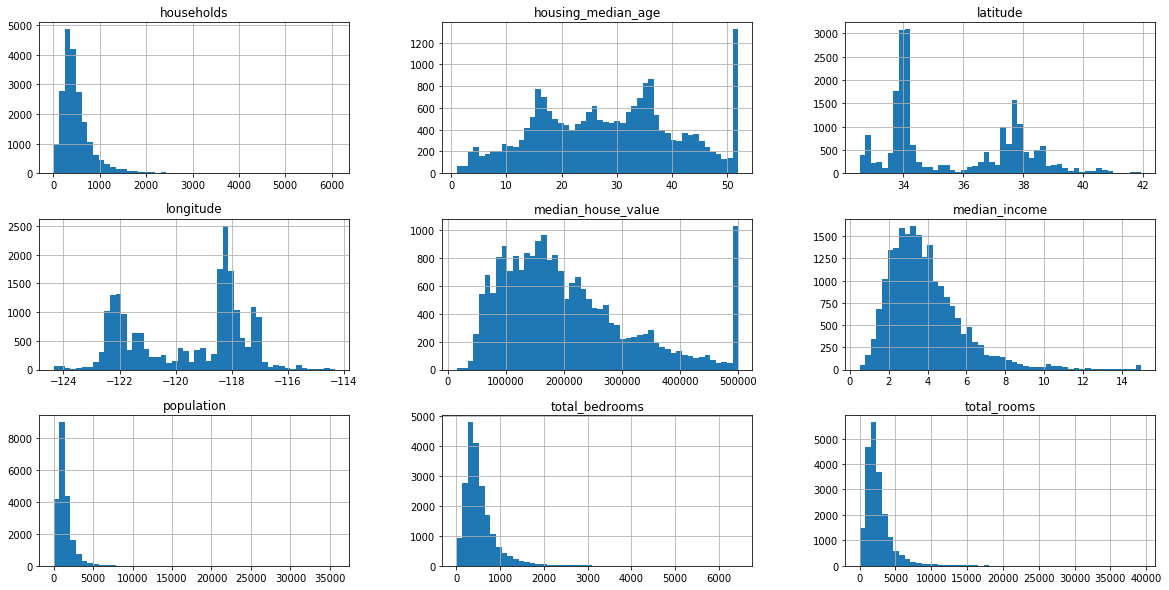

In [9]:
housing.hist(bins=50, figsize=(20,10))

## Set aside the test data

### local implementation...

In [10]:
import numpy as np

def split_test_train(data, test_ratio=0.2):
    N = len(data) # total dataset size
    shuffled_indices = np.random.permutation(N)
    M = int(N * test_ratio) # test dataset size
    return data.iloc[shuffled_indices[M:]], data.iloc[shuffled_indices[:M]]

np.random.seed(42)
train_set, test_set = split_test_train(housing)

In [11]:
(train_set.shape, test_set.shape)

((16512, 10), (4128, 10))

### using scikit learn...

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
(train_set.shape, test_set.shape)

((16512, 10), (4128, 10))

### stratified sampling by income...

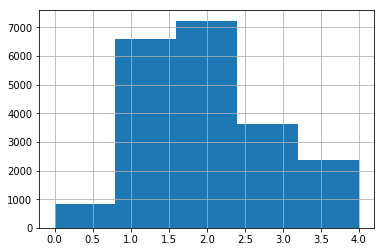

In [14]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=range(5))
housing['income_cat'].hist(bins=5)

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
train_index, test_index = next(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(housing, housing['income_cat'].astype(int)))
strat_train_set = housing.loc[train_index]
strat_test_set = housing.loc[test_index]

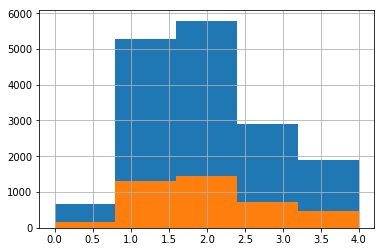

In [17]:
strat_train_set['income_cat'].hist(bins=5)
strat_test_set['income_cat'].hist(bins=5)

Drop the extra column used for stratifying the data

In [18]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

In [19]:
d = strat_train_set

### Geographic visualization

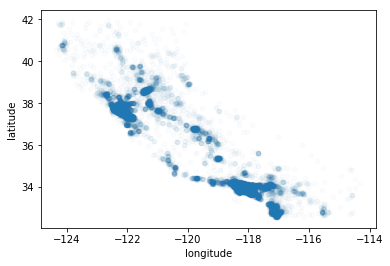

In [20]:
d.plot(kind='scatter', x='longitude', y='latitude', alpha=0.02)

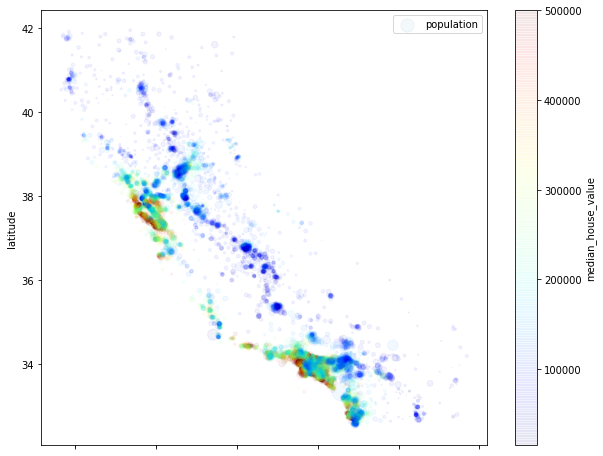

In [21]:
d.plot(kind='scatter', x='longitude', y='latitude', alpha=0.05, s=d['population']/100, label='population', c='median_house_value', cmap='jet', figsize=(10,8))

In [22]:
d.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [23]:
d.corr().median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

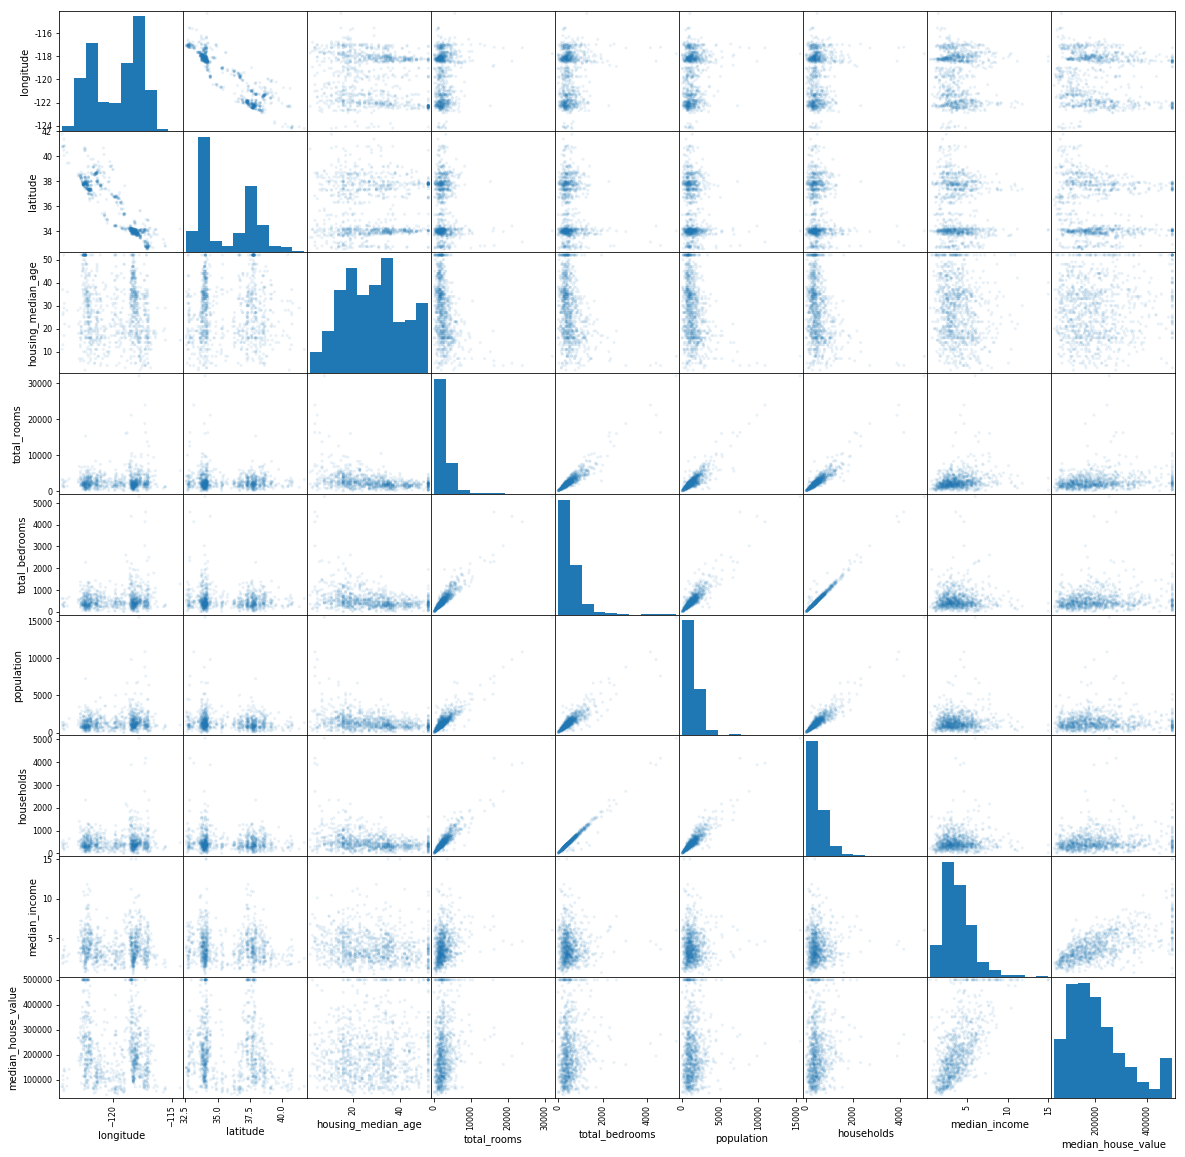

In [24]:
pd.plotting.scatter_matrix(d.head(1000), figsize=(20,20), alpha=0.1)
pass

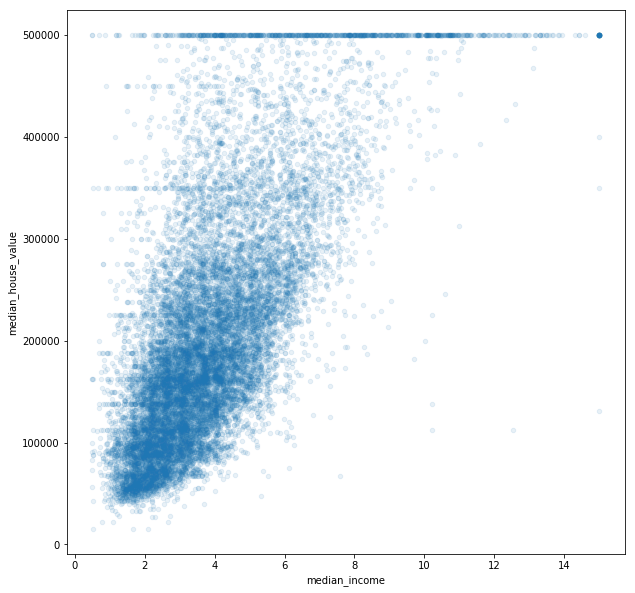

In [25]:
d.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10,10))

Add a few derived attributes...

In [26]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [27]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

Start over again with fresh data, separating the features from the labels.

In [28]:
housing_features = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Make a version of housing for numeric features.

In [29]:
housing_num = housing_features.drop('ocean_proximity', axis=1)

#### Train an imputer for missing data (e.g. in total_bedrooms).

In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [31]:
imputer.statistics_ / housing_num.median()

longitude             1.0
latitude              1.0
housing_median_age    1.0
total_rooms           1.0
total_bedrooms        1.0
population            1.0
households            1.0
median_income         1.0
dtype: float64

In [32]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [33]:
def transform_df(transform, df):
    return pd.DataFrame(transform.transform(df), columns=df.columns, index=df.index)

In [34]:
housing_tr = transform_df(imputer, housing_num)

In [35]:
housing_num['total_bedrooms'].describe()

count    16354.000000
mean       534.973890
std        412.699041
min          2.000000
25%        295.000000
50%        433.000000
75%        644.000000
max       6210.000000
Name: total_bedrooms, dtype: float64

In [36]:
housing_tr['total_bedrooms'].describe()

count    16512.000000
mean       533.998123
std        410.839621
min          2.000000
25%        296.000000
50%        433.000000
75%        641.000000
max       6210.000000
Name: total_bedrooms, dtype: float64

In [37]:
housing_num['total_bedrooms'].isna().sum(), housing_tr['total_bedrooms'].isna().sum()

(158, 0)

#### Handle categorical data

In [38]:
housing_features['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [39]:
housing_cat = housing_features[['ocean_proximity']]

In [40]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(housing_cat)
housing_cat_encoded = transform_df(ordinal_encoder, housing_cat)

In [41]:
housing_cat_encoded.head()

,ocean_proximity
17606,0.0
18632,0.0
14650,4.0
3230,1.0
3555,0.0


In [42]:
housing_cat_encoded['ocean_proximity'].value_counts()

0.0    7276
1.0    5263
4.0    2124
3.0    1847
2.0       2
Name: ocean_proximity, dtype: int64

In [43]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(housing_cat)
housing_cat_one_hot = one_hot_encoder.transform(housing_cat)

In [44]:
housing_cat_one_hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [45]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Transform for adding derived parameters

In [187]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddDerivedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            columns=X.columns
        elif X.shape[1] == housing_features.shape[1]:
            columns=housing_features.columns
        elif X.shape[1] == housing_num.shape[1]:
            columns=housing_num.columns
        else:
            raise ValueError('no column labels provided and shape does not match housing or housing_num')
        self.i_total_rooms_ = columns.get_loc('total_rooms')
        self.i_total_bedrooms_ = columns.get_loc('total_bedrooms')
        self.i_population_ = columns.get_loc('population')
        self.i_households_ = columns.get_loc('households')
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, self.i_total_rooms_] / X[:, self.i_households_]
        population_per_household = X[:, self.i_population_] / X[:, self.i_households_]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.i_total_bedrooms_] / X[:, self.i_total_rooms_]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

feature_adder = AddDerivedFeatures(False)
housing_derived_features = feature_adder.fit_transform(housing_features.values)

In [47]:
housing_derived_features[0]

array([-121.89, 37.29, 38.0, 1568.0, 351.0, 710.0, 339.0, 2.7042,
       '<1H OCEAN', 4.625368731563422, 2.094395280235988], dtype=object)

Pipeline to transform the numeric data

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

scalar_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', AddDerivedFeatures()),
    ('std_scaler', StandardScaler()),
])

housing_num_hat = scalar_pipeline.fit_transform(housing_num)

Combine the categorical and scalar transforms into a single pipeline

In [49]:
from sklearn.compose import ColumnTransformer

scalar_columns = list(housing_num.columns)
categorical_columns = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("scalar", scalar_pipeline, scalar_columns),
    ("categorical", OneHotEncoder(), categorical_columns)
])

transformed_housing = full_pipeline.fit_transform(housing_features)

Train a linear regression model

In [50]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(transformed_housing, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Try using the model for predictions

(0, 600001.2)

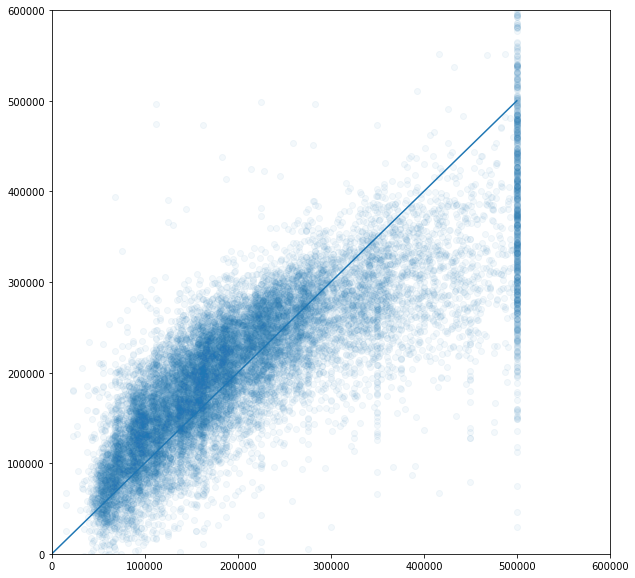

In [51]:
lm_housing_predictions = lm.predict(full_pipeline.transform(housing_features))
plt.figure(figsize=(10,10))
plt.plot((0, max(housing_labels)), (0, max(housing_labels)))
plt.scatter(housing_labels, lm_housing_predictions, alpha=0.05)
plt.xlim(0, 1.2*max(housing_labels))
plt.ylim(0, 1.2*max(housing_labels))

Calculate RMSE

In [52]:
from sklearn.metrics import mean_squared_error

linear_regression_rmse = np.sqrt(mean_squared_error(housing_labels, lm_housing_predictions))
linear_regression_rmse

68628.19819848922

Train a decision tree model (badly)

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(transformed_housing, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

0.0

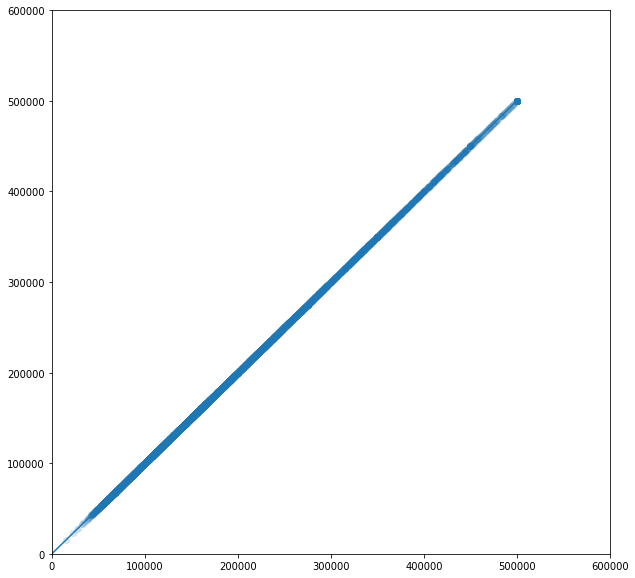

In [54]:
tr_housing_predictions = tree_regressor.predict(full_pipeline.transform(housing_features))
plt.figure(figsize=(10,10))
plt.plot((0, max(housing_labels)), (0, max(housing_labels)))
plt.scatter(housing_labels, tr_housing_predictions, alpha=0.05)
plt.xlim(0, 1.2*max(housing_labels))
plt.ylim(0, 1.2*max(housing_labels))
np.sqrt(mean_squared_error(housing_labels, tr_housing_predictions))

Try evaluating this with cross-validation

In [55]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_regressor, transformed_housing, housing_labels, scoring="neg_mean_squared_error", cv=10)
print(f'{np.mean(np.sqrt(-scores))} +/- {np.std(np.sqrt(-scores))}')

70666.74616904806 +/- 2928.322738055112


In [56]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lm, transformed_housing, housing_labels, scoring="neg_mean_squared_error", cv=10)
print(f'{np.mean(np.sqrt(-scores))} +/- {np.std(np.sqrt(-scores))}')

69052.46136345083 +/- 2731.674001798348


Try a random forrest regressor

In [91]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(transformed_housing, housing_labels)

/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

22588.669347520365

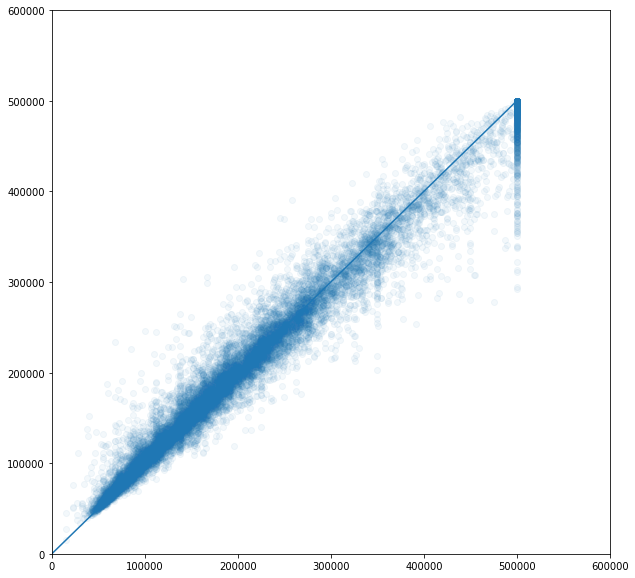

In [92]:
rf_housing_predictions = rf.predict(full_pipeline.transform(housing_features))
plt.figure(figsize=(10,10))
plt.plot((0, max(housing_labels)), (0, max(housing_labels)))
plt.scatter(housing_labels, rf_housing_predictions, alpha=0.05)
plt.xlim(0, 1.2*max(housing_labels))
plt.ylim(0, 1.2*max(housing_labels))
np.sqrt(mean_squared_error(housing_labels, rf_housing_predictions))

In [137]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, transformed_housing, housing_labels, scoring="neg_mean_squared_error", cv=10)
print(f'{np.mean(np.sqrt(-scores))} +/- {np.std(np.sqrt(-scores))}')

52716.74204569494 +/- 2061.6901569871115


Example of loading and saving a model with joblib

In [64]:
import joblib

joblib.dump(rf, "/home/kms15/tmp/rf.pkl")
rf2 = joblib.load("/home/kms15/tmp/rf.pkl")

Example of a grid-search for hyperparameters

In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [80,100,120,130,140], 'max_features': [4, 6, 7, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

rf = RandomForestRegressor()

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=84)

grid_search.fit(transformed_housing, housing_labels)

/home/kms15/jupyter/jupyter_venv/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=84,
       param_grid=[{'n_estimators': [80, 100, 120, 130, 140], 'max_features': [4, 6, 7, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [85]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 120}

In [86]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [89]:
cvr = grid_search.cv_results_
for mean_score, params in zip(cvr['mean_test_score'], cvr['params']):
    print(f'{np.sqrt(-mean_score):0.2f}, {params}')

49675.97, {'max_features': 4, 'n_estimators': 80}
49803.70, {'max_features': 4, 'n_estimators': 100}
49672.71, {'max_features': 4, 'n_estimators': 120}
49656.12, {'max_features': 4, 'n_estimators': 130}
49584.18, {'max_features': 4, 'n_estimators': 140}
49384.82, {'max_features': 6, 'n_estimators': 80}
49283.94, {'max_features': 6, 'n_estimators': 100}
49009.09, {'max_features': 6, 'n_estimators': 120}
49290.85, {'max_features': 6, 'n_estimators': 130}
49269.54, {'max_features': 6, 'n_estimators': 140}
49366.10, {'max_features': 7, 'n_estimators': 80}
49300.51, {'max_features': 7, 'n_estimators': 100}
49194.39, {'max_features': 7, 'n_estimators': 120}
49257.29, {'max_features': 7, 'n_estimators': 130}
49172.13, {'max_features': 7, 'n_estimators': 140}
49482.33, {'max_features': 8, 'n_estimators': 80}
49309.16, {'max_features': 8, 'n_estimators': 100}
49234.98, {'max_features': 8, 'n_estimators': 120}
49273.61, {'max_features': 8, 'n_estimators': 130}
49332.64, {'max_features': 8, 'n_es

18068.58121016608

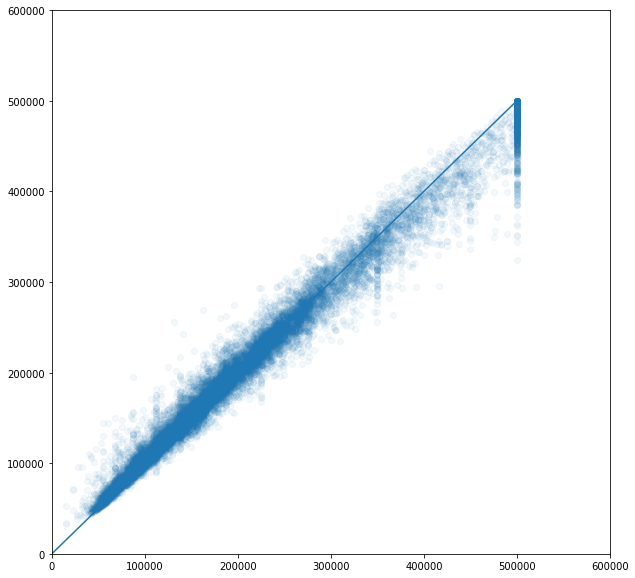

In [93]:
gsrf_housing_predictions = grid_search.best_estimator_.predict(full_pipeline.transform(housing_features))
plt.figure(figsize=(10,10))
plt.plot((0, max(housing_labels)), (0, max(housing_labels)))
plt.scatter(housing_labels, gsrf_housing_predictions, alpha=0.05)
plt.xlim(0, 1.2*max(housing_labels))
plt.ylim(0, 1.2*max(housing_labels))
np.sqrt(mean_squared_error(housing_labels, gsrf_housing_predictions))

In [96]:
gsrf = grid_search.best_estimator_
scores = cross_val_score(gsrf, transformed_housing, housing_labels, scoring="neg_mean_squared_error", cv=10, n_jobs=88)
print(f'{np.mean(np.sqrt(-scores))} +/- {np.std(np.sqrt(-scores))}')

48817.94154522794 +/- 1838.15534602167


In [100]:
gsrf.feature_importances_

array([7.79176177e-02, 6.83014897e-02, 4.18334357e-02, 1.78457432e-02,
       1.69166808e-02, 1.75057496e-02, 1.62564471e-02, 3.11619509e-01,
       6.20697194e-02, 1.08772929e-01, 8.01656922e-02, 9.97046619e-03,
       1.62324311e-01, 5.93719821e-05, 3.50111441e-03, 4.93972289e-03])

Try running on the actual data

In [105]:
housing_test_features = strat_test_set.drop('median_house_value', axis=1)
housing_test_labels = strat_test_set['median_house_value'].copy()
transformed_test_housing = full_pipeline.transform(housing_test_features)

In [106]:
gsrf.fit(transformed_housing, housing_labels)
final_model = gsrf

In [109]:
test_predictions = final_model.predict(transformed_test_housing)

In [116]:
squared_errors = (housing_test_labels - test_predictions)**2
final_rmse = np.sqrt(np.mean(squared_errors))
final_rmse

46708.893154039164

Generate a 95% confidence interval

In [117]:
from scipy import stats
np.sqrt(stats.t.interval(0.95, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([44771.40560931, 48569.1531645 ])

## Exercises

## 1

Try a random forrest regressor

In [212]:
def evaluate_model(m, X=transformed_housing):
    m.fit(X, housing_labels)
    predictions = m.predict(X)
    plt.figure(figsize=(10,10))
    plt.plot((0, max(housing_labels)), (0, max(housing_labels)))
    plt.scatter(housing_labels, predictions, alpha=0.05)
    plt.xlim(0, 1.2*max(housing_labels))
    plt.ylim(0, 1.2*max(housing_labels))

    scores = cross_val_score(m, X, housing_labels, scoring="neg_mean_squared_error", cv=10, n_jobs=10)
    plt.title(f'MSE = {np.mean(np.sqrt(-scores))} +/- {np.std(np.sqrt(-scores))}')

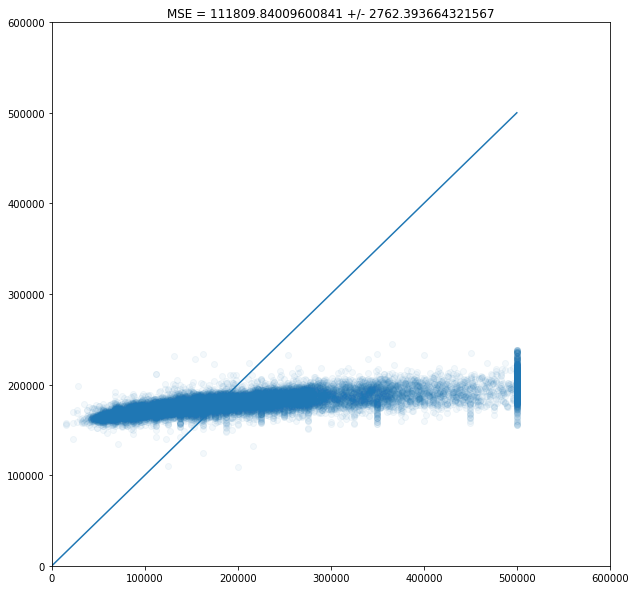

In [157]:
from sklearn.svm import SVR

evaluate_model(SVR(kernel="linear", C=1))

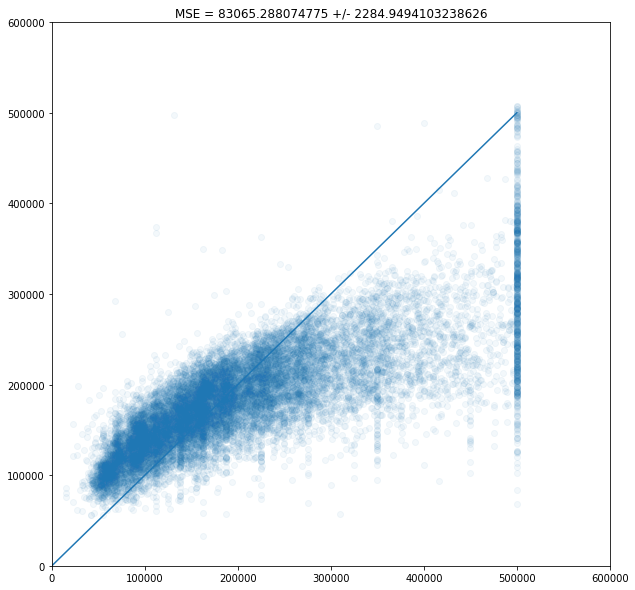

In [158]:
evaluate_model(SVR(kernel="linear", C=1e1))

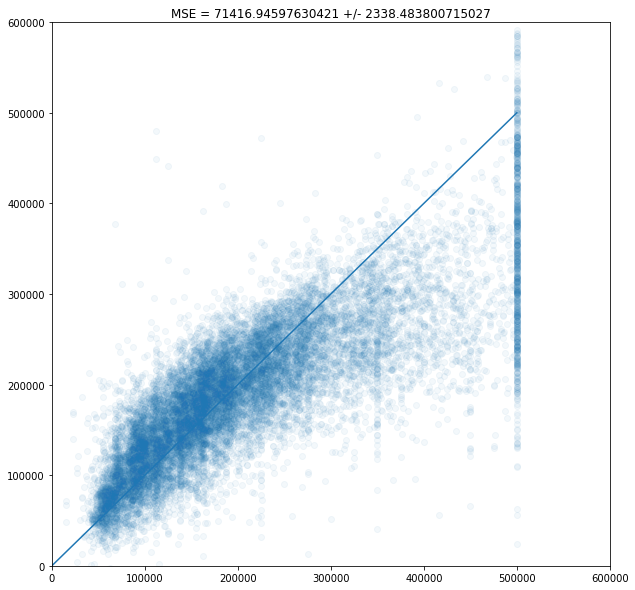

In [156]:
evaluate_model(SVR(kernel="linear", C=1e2))

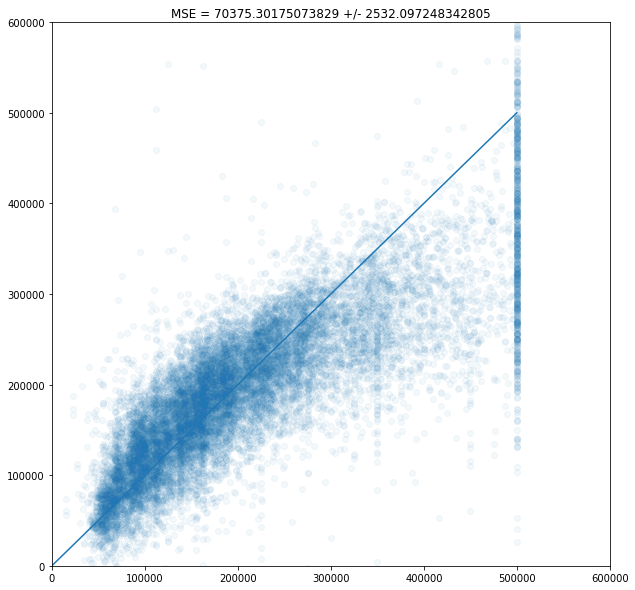

In [159]:
evaluate_model(SVR(kernel="linear", C=1e3))

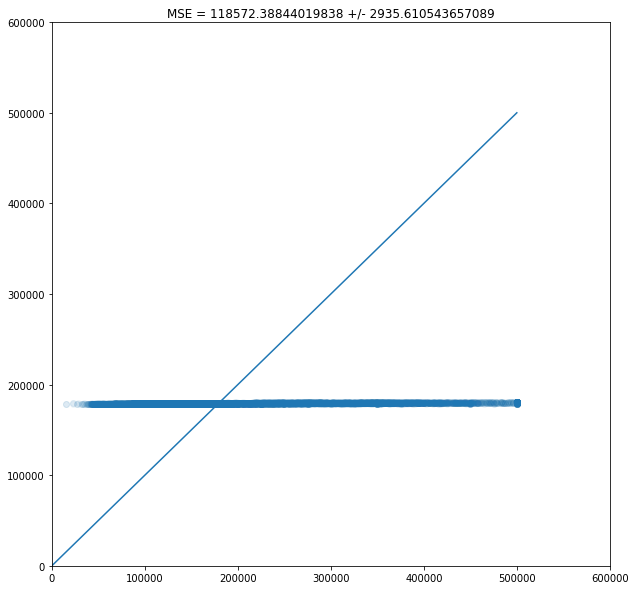

In [160]:
evaluate_model(SVR(kernel="rbf", C=1, gamma="scale"))

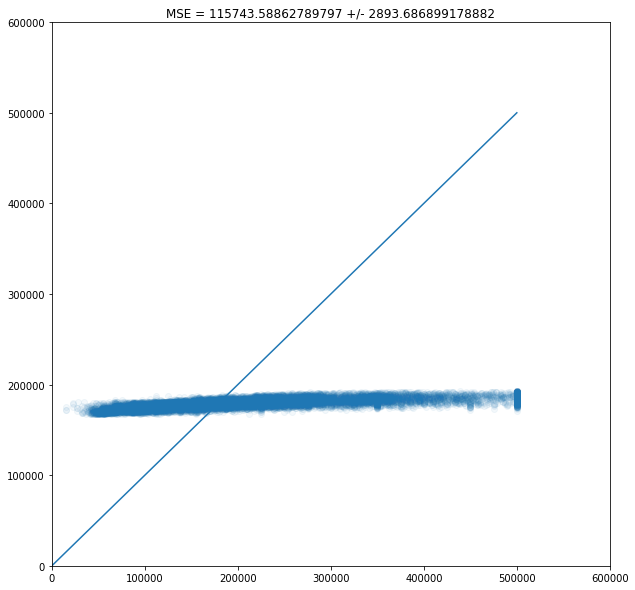

In [161]:
evaluate_model(SVR(kernel="rbf", C=10, gamma="scale"))

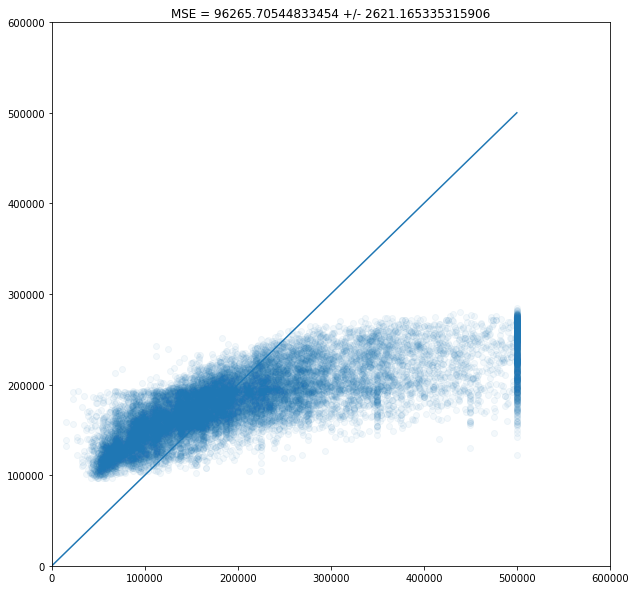

In [162]:
evaluate_model(SVR(kernel="rbf", C=100, gamma="scale"))

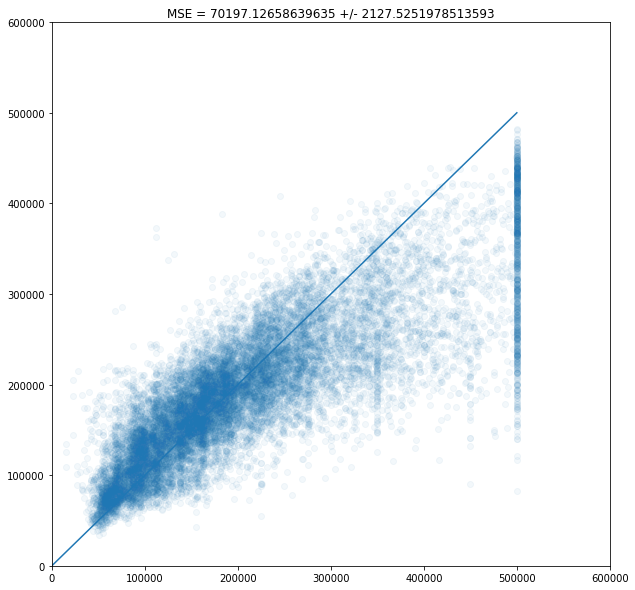

In [164]:
evaluate_model(SVR(kernel="rbf", C=1000, gamma="scale"))

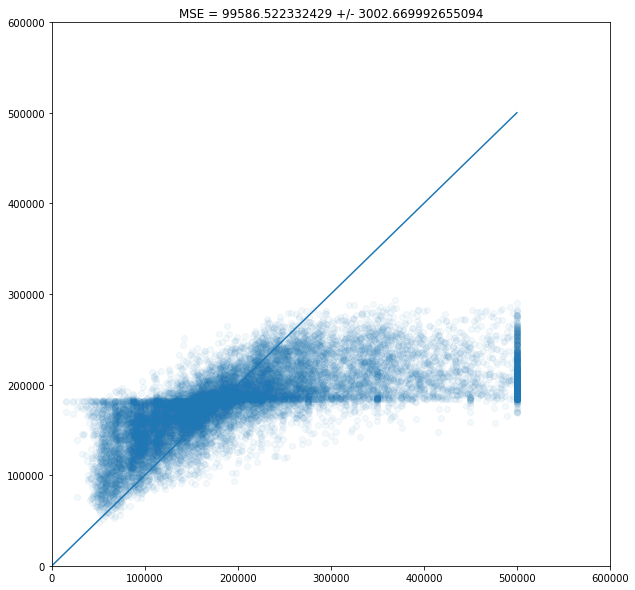

In [165]:
evaluate_model(SVR(kernel="rbf", C=1000, gamma=1))

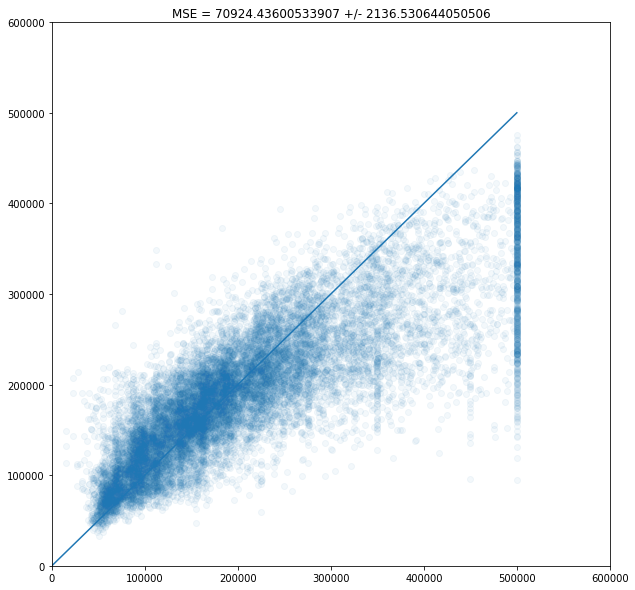

In [167]:
evaluate_model(SVR(kernel="rbf", C=1000, gamma=1e-1))

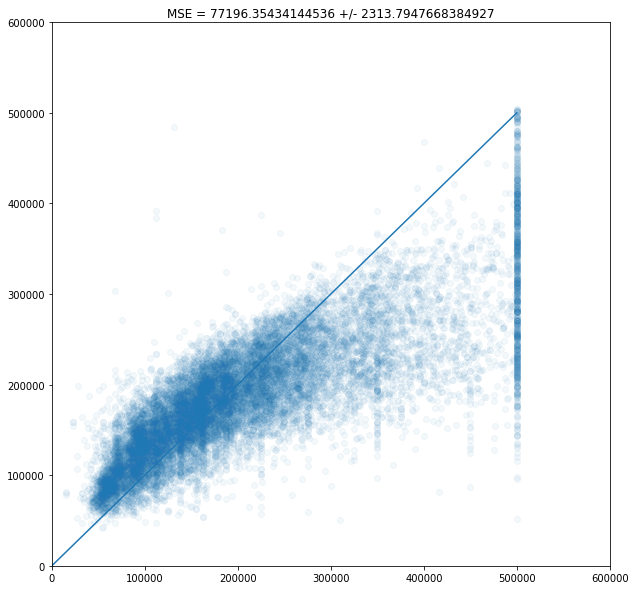

In [166]:
evaluate_model(SVR(kernel="rbf", C=1000, gamma=1e-2))

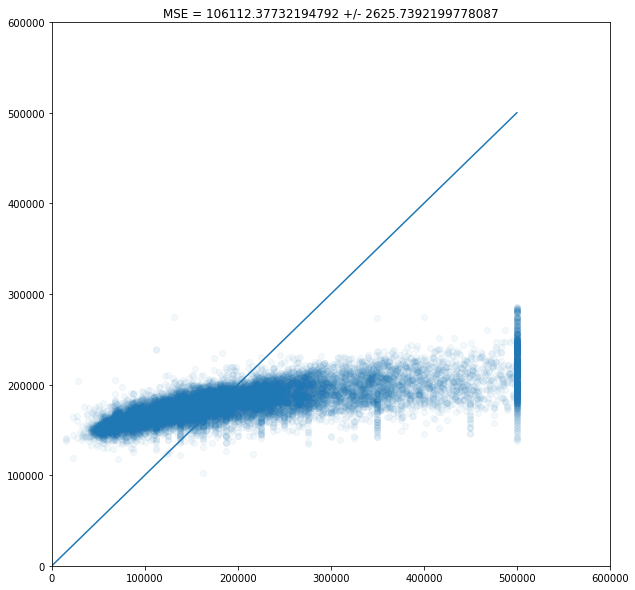

In [168]:
evaluate_model(SVR(kernel="rbf", C=1000, gamma=1e-3))

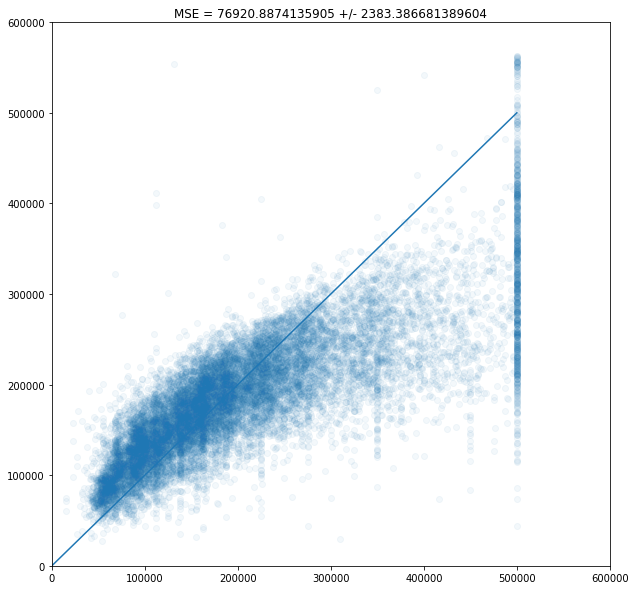

In [169]:
evaluate_model(SVR(kernel="rbf", C=10000, gamma=1e-3))

## 2

In [178]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
param_dist = {'n_estimators': stats.randint(1,500), 'max_features': stats.randint(1,transformed_housing.shape[1])}

random_search = RandomizedSearchCV(rf, param_dist, n_iter=88, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=88)
random_search.fit(transformed_housing, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=88, n_jobs=88,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1d124a9048>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1d12521c50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

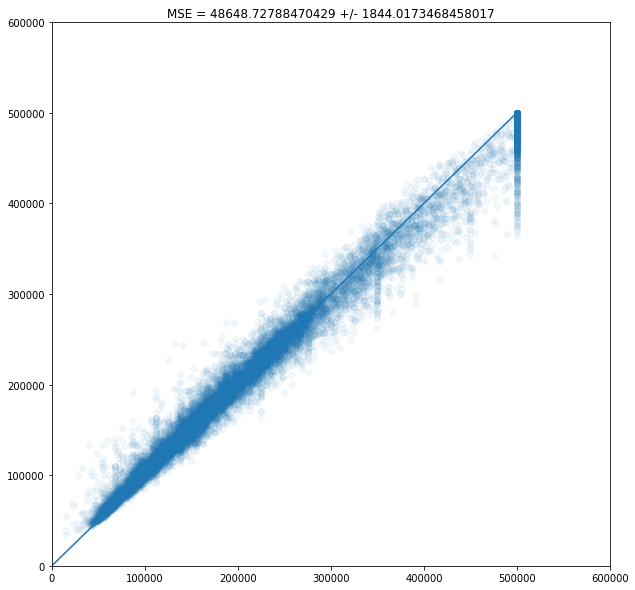

In [179]:
evaluate_model(random_search.best_estimator_)

In [180]:
random_search.best_params_

{'max_features': 7, 'n_estimators': 481}

## 3

In [181]:
random_search.best_estimator_.feature_importances_

array([7.29093730e-02, 6.62959421e-02, 4.30807140e-02, 1.62254228e-02,
       1.54866474e-02, 1.61219347e-02, 1.52408408e-02, 3.52144483e-01,
       5.32402485e-02, 1.10361982e-01, 7.01844788e-02, 8.75631741e-03,
       1.53265473e-01, 6.80946698e-05, 2.46330405e-03, 4.15474354e-03])

In [206]:
importances = random_search.best_estimator_.feature_importances_

class DiscardLessImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target_num_features=5):
        self.target_num_features = target_num_features
    
    def fit(self, X, y=None):
        sorted_importances = np.sort(importances)[::-1]
        importance_threshold = sorted_importances[self.target_num_features - 1]
        self.importance_mask_ = importances >= importance_threshold
        return self
    
    def transform(self, X, y=None):
        return X[:,self.importance_mask_]

Combine the categorical and scalar transforms into a single pipeline

In [207]:
legacy_pipeline = full_pipeline

filtering_pipeline = Pipeline([
    ('legacy', legacy_pipeline),
    ('filter', DiscardLessImportantFeatures())
])

filtered_housing = filtering_pipeline.fit_transform(housing_features)

In [208]:
filtered_housing.shape

(16512, 5)

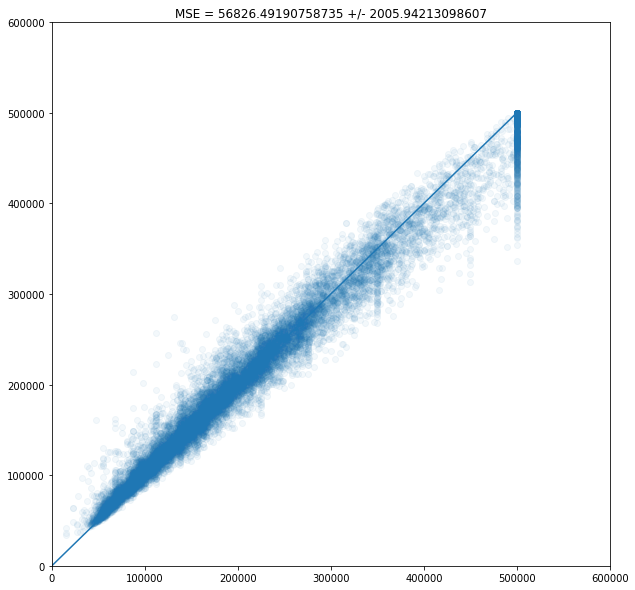

In [213]:
evaluate_model(RandomForestRegressor(max_features=5, n_estimators=400), filtered_housing)